In [1]:
%reload_ext autoreload
%autoreload 2

import sys
sys.path.append("..")

import numpy as np
import healpy as hp
from astropy.io import fits
from pprint import pprint
from tqdm import tqdm
import pickle
import corner
import os
import arviz as az

from scipy import optimize
from scipy.stats import poisson

import jax
import jax.numpy as jnp

%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc_file('../utils/matplotlibrc')

from utils import ed_fcts as ef

In [2]:
# first, load samples from each run

# load SVI fit results (these should be the only parameters that you are loading)
gpu_id = '0'

# sim name
sim_name = 'canon_g1_pnfw'

# load SVI fit results (these should be the only parameters that you are loading)
sim_id = 7.1234567
temp_id = 5.23457
gp_id = 1.16
blg_id = -1
mod_id = 0
svi_id = 0

# variable inputs
sim_seeds = np.arange(10)
svi_seeds = np.arange(0,1)

In [3]:
# load GPU
os.environ['XLA_PYTHON_CLIENT_PREALLOCATE'] = 'false'
os.environ['CUDA_VISIBLE_DEVICES'] = gpu_id

data_dir = ef.load_data_dir(sim_name)
os.system("mkdir -p "+data_dir)

# Load the simulated templates
## NOTE: This information should already be taken into account once
## specifying the relevant IDs ; however, this is a good way to double-check
## you're loading what you want
ebin = 10

temp_dict = np.load(data_dir + 'all_templates_ebin' + str(ebin)  + '.npy', allow_pickle=True).item()

In [4]:
sim_seed = 0
svi_seed = 0

fit_filename, module_name = ef.generate_fit_filename_from_ids(sim_id, temp_id, gp_id, blg_id, mod_id, svi_id, sim_seed, svi_seed)
fit_dir = data_dir + 'fits/' + fit_filename + '/'
ef.list_files(fit_dir)

sys.path.append(fit_dir)
import importlib 
module = importlib.import_module(module_name)

# Load all the variables from the module
globals().update(vars(module))

file_name = ('ebin' + str_ebin + '_smp_svi_' + 
             str_lr + '_' + str_n_steps + '_' + 
                str_guide + '_' + str_num_particles + '_' + 
                str_sim_seed + '_' + str_svi_seed + '.p')

if is_gp:
   samples, svi_results, gp_samples = pickle.load(open(fit_dir + file_name, 'rb'))
else:
   samples, svi_results = pickle.load(open(fit_dir + file_name, 'rb'))

/
    ebin10_smp_svi_0.01_20000_mvn_16_0_0.p
    settings_7p1234567_5p23457_1p16_-1_0_0_0_0.py
    __init__.py
    summary.txt
__pycache__/
    settings_7p1234567_5p23457_1p16_-1_0_0_0_0.cpython-311.pyc


/home/edr76/.conda/envs/jax/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [5]:
print(jnp.exp(gp_samples).sum(axis = 1))

[2082.1792 1643.0005 1546.3923 1805.0967 1816.4827 2150.3032 1768.5325
 1795.3352 1816.3582 2175.5532 2148.4355 2055.3965 2563.966  1855.696
 1619.1985 1754.662  1523.0856 1598.0437 1934.212  1715.7561 2168.8616
 1708.4941 1677.2158 2805.8892 1914.6111 2066.241  1759.1792 2041.6976
 1591.1128 2101.79   1642.5458 1602.166  1352.1042 1881.8562 2036.7361
 1433.2811 2344.259  2099.5005 2165.3645 1888.5431 1837.6143 1799.4429
 2075.4111 1727.6511 1686.1692 1702.656  1575.1165 1536.6902 1497.1812
 1869.9579 1842.0698 2335.5623 1971.5011 1848.5427 2216.6365 1611.0728
 1775.2502 2087.9424 1923.9396 1583.4326 1908.7094 2203.6963 2008.4163
 1766.4396 1813.73   2246.1653 1472.2533 1620.2349 1707.9888 2153.5557
 1979.074  1562.0193 1947.4678 1742.528  2283.7925 2090.8564 1530.0199
 2271.0981 1688.3542 2071.2642 1690.7329 1679.0045 1410.6511 1902.5507
 1315.1704 1650.6096 2357.203  1804.144  2453.3025 1702.2996 1945.7756
 2062.0315 1904.1992 2136.306  1719.2875 2074.5474 1687.7273 2452.2747
 1976.1

In [6]:
# TODO: Probably a better way to collect this data; 
# for example, make a dictionary whose inputs are ordered pairs of the variable inputs

samples_svi_sim = []
svi_results_svi_sim = []
gp_samples_svi_sim = []

for svi_seed in tqdm(svi_seeds, desc = 'svi_seeds'):
    samples_sim = []
    svi_results_sim = []
    gp_samples_sim = []
    for sim_seed in tqdm(sim_seeds, desc = 'sim_seeds'):
        # if fit_dir in sys.path:
        #     sys.path.pop(-1)
        fit_filename, module_name = ef.generate_fit_filename_from_ids(sim_id, temp_id, gp_id, blg_id, mod_id, svi_id, sim_seed, svi_seed)
        fit_dir = data_dir + 'fits/' + fit_filename + '/'

        sys.path.append(fit_dir)
        import importlib 
        module = importlib.import_module(module_name)

        # Load all the variables from the module
        globals().update(vars(module))

        file_name = ('ebin' + str_ebin + '_smp_svi_' + 
                     str_lr + '_' + str_n_steps + '_' + 
                        str_guide + '_' + str_num_particles + '_' + 
                        str_sim_seed + '_' + str_svi_seed + '.p')

        if is_gp:
           samples, svi_results, gp_samples = pickle.load(open(fit_dir + file_name, 'rb'))
        else:
           samples, svi_results = pickle.load(open(fit_dir + file_name, 'rb'))
        
        samples_sim.append(samples)
        svi_results_sim.append(svi_results)
        gp_samples_sim.append(gp_samples)
        
    samples_svi_sim.append(samples_sim)
    svi_results_svi_sim.append(svi_results_sim)
    gp_samples_svi_sim.append(gp_samples_sim)

svi_seeds:   0%|          | 0/1 [00:00<?, ?it/s]

svi_seeds: 100%|██████████| 1/1 [00:00<00:00,  4.34it/s]


In [7]:
from models.poissonian_ed import EbinPoissonModel # to set GPU at the beginning

ebinmodel = EbinPoissonModel(
        # all parameters
        rig_temp_list = rig_temp_list,
        hyb_temp_list = hyb_temp_list,
        var_temp_list = var_temp_list,
        is_gp = is_gp,
        gp_deriv = gp_deriv,
        data_file = data_file,
        rig_temp_sim = rig_temp_sim,
        hyb_temp_sim = hyb_temp_sim,
        var_temp_sim = var_temp_sim,
        is_custom_blg= is_custom_blg,
        custom_blg_id = custom_blg_id,
        sim_seed = sim_seed,
        Nu = Nu,
        u_option = u_option,
        u_grid_type = u_grid_type,
        u_weights = u_weights,
        Np = Np,
        p_option = p_option,
        Nsub = Nsub,
        ebin = ebin,
        is_float64 = is_float64,
        debug_nans = debug_nans,
        no_ps_mask = no_ps_mask,
        p_grid_type = p_grid_type,
        p_weights = p_weights,
        gp_kernel = gp_kernel,
        gp_params = gp_params,
        gp_scale_option = gp_scale_option,
        monotonicity_hyperparameter = monotonicity_hyperparameter,
        nfw_gamma = nfw_gamma,
        )
ebinmodel.config_model(ebin=ebin)

[autoreload of __main__ failed: Traceback (most recent call last):
  File "/home/edr76/.conda/envs/jax/lib/python3.11/site-packages/IPython/extensions/autoreload.py", line 276, in check
    superreload(m, reload, self.old_objects)
  File "/home/edr76/.conda/envs/jax/lib/python3.11/site-packages/IPython/extensions/autoreload.py", line 475, in superreload
    module = reload(module)
             ^^^^^^^^^^^^^^
  File "/home/edr76/.conda/envs/jax/lib/python3.11/importlib/__init__.py", line 148, in reload
    raise ImportError(msg.format(name), name=name)
ImportError: module settings_7p1234567_5p23457_1p16_-1_0_0_9_0 not in sys.modules
]


In [8]:
temp_names_sim = rig_temp_sim + hyb_temp_sim + var_temp_sim # imported from settings file

temp_sample_dict_svi_sim = []

# NOTE: Indices now don't track the IDs. So, you need to keep track of the indices
Ncs = len(svi_seeds)
Ncr = len(sim_seeds)
for ns in tqdm(range(Ncs), desc = 'svi_seeds'):
    temp_sample_dict_sim = []
    for nr in tqdm(range(Ncr), desc = 'sim_seeds'):
        samples = samples_svi_sim[ns][nr]
        gp_samples = gp_samples_svi_sim[ns][nr]
        temp_sample_dict = ef.generate_temp_sample_maps(samples, ebinmodel, gp_samples = gp_samples, custom_num=1000, nfw_gamma=nfw_gamma)
        temp_sample_dict_sim.append(temp_sample_dict)
    temp_sample_dict_svi_sim.append(temp_sample_dict_sim)

svi_seeds:   0%|          | 0/1 [00:00<?, ?it/s]

iso
psc
bub
pib






























100%|██████████| 1000/1000 [00:03<00:00, 325.62it/s]


ics





























100%|██████████| 1000/1000 [00:02<00:00, 359.68it/s]


iso
psc
bub
pib





























100%|██████████| 1000/1000 [00:02<00:00, 362.00it/s]


ics




























100%|██████████| 1000/1000 [00:02<00:00, 365.24it/s]


iso
psc
bub
pib




























100%|██████████| 1000/1000 [00:02<00:00, 369.46it/s]


ics





























100%|██████████| 1000/1000 [00:02<00:00, 359.47it/s]


iso
psc
bub
pib



























100%|██████████| 1000/1000 [00:02<00:00, 379.04it/s]


ics


























100%|██████████| 1000/1000 [00:02<00:00, 396.79it/s]


iso
psc
bub
pib























100%|██████████| 1000/1000 [00:02<00:00, 440.85it/s]


ics





























100%|██████████| 1000/1000 [00:02<00:00, 360.42it/s]


iso
psc
bub
pib































100%|██████████| 1000/1000 [00:03<00:00, 325.39it/s]


ics




























100%|██████████| 1000/1000 [00:02<00:00, 366.20it/s]


iso
psc
bub
pib



























100%|██████████| 1000/1000 [00:02<00:00, 385.69it/s]


ics



























100%|██████████| 1000/1000 [00:02<00:00, 381.43it/s]


iso
psc
bub
pib



























100%|██████████| 1000/1000 [00:02<00:00, 379.86it/s]


ics





























100%|██████████| 1000/1000 [00:02<00:00, 351.87it/s]


iso
psc
bub
pib



























100%|██████████| 1000/1000 [00:02<00:00, 386.56it/s]


ics


























100%|██████████| 1000/1000 [00:02<00:00, 406.48it/s]


iso
psc
bub
pib



























100%|██████████| 1000/1000 [00:02<00:00, 376.09it/s]


ics




























svi_seeds: 100%|██████████| 1/1 [00:56<00:00, 56.79s/it]


svi_seeds:   0%|          | 0/1 [00:00<?, ?it/s]

svi_seeds: 100%|██████████| 1/1 [00:01<00:00,  1.33s/it]


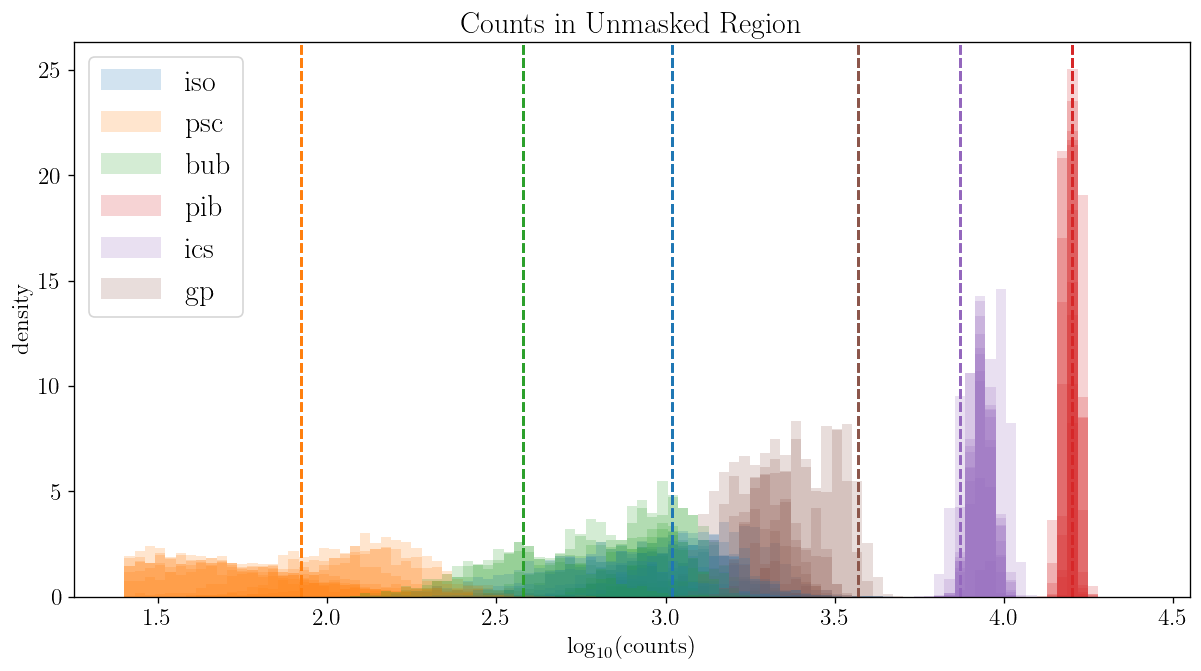

In [9]:
fig = plt.figure(figsize=(12, 6), dpi= 120)
ax = fig.add_subplot(111)

bins = np.linspace(1.4,4.4,100)
alpha = 0.2
histtype = 'stepfilled'

all_temp_names = ['iso', 'psc', 'bub', 'pib', 'ics', 'blg', 'gp', 'nfw', 'dsk']
ccodes = ['C0', 'C1', 'C2', 'C3', 'C4', 'C5', 'C5', 'C6', 'C7']
names = list(temp_sample_dict.keys())
ordered_names = [name for name in all_temp_names if name in names]

Ncs = len(svi_seeds)
Ncr = len(sim_seeds)
c = 0
for ns in tqdm(range(Ncs), desc = 'svi_seeds'):
    for nr in tqdm(range(Ncr), desc = 'sim_seeds'):
        temp_sample_dict = temp_sample_dict_svi_sim[ns][nr]
        for k in range(len(ordered_names)):
            name = ordered_names[k]
            idx = all_temp_names.index(name)
            ccode = ccodes[idx]
            # if name == 'gp':
            #     temp_sum = jnp.exp(temp_sample_dict[name]).sum(axis = 1) # sum over spatial bins
            #     ax.hist(np.log10(temp_sum), bins = bins, alpha = 0.75, label = name, density = True, histtype = 'step', color = ccode)
            # else:
            temp_sum = temp_sample_dict[name].sum(axis = 1) # sum over spatial bins
            if c == 0:
                ax.hist(np.log10(temp_sum), bins = bins, alpha = alpha, label = name, density = True, histtype = histtype, color = ccode)
            else:
                ax.hist(np.log10(temp_sum), bins = bins, alpha = alpha, density = True, histtype = histtype, color = ccode)

        if temp_dict is not None:
            names_sim = temp_names_sim # this piece is provided by the "settings" file since we only save a dictionary with all the fit parameters
            ordered_names_sim = [name for name in all_temp_names if name in names_sim]
            for k in range(len(ordered_names_sim)):
                name = ordered_names_sim[k]
                idx = all_temp_names.index(name)
                ccode = ccodes[idx]
                if ordered_names_sim[k] == 'nfw':
                    continue
                elif ordered_names_sim[k] == 'blg':
                    temp_sum_sim = temp_dict['blg'].sum(axis = 0) + temp_dict['nfw'].sum(axis = 0)
                    ax.axvline(np.log10(temp_sum_sim), linestyle='--', c = ccode)
                else:
                    temp_sum_sim = temp_dict[name].sum(axis = 0)
                    ax.axvline(np.log10(temp_sum_sim), linestyle='--', c = ccode)
        c += 1
        
        ax.legend()
        ax.set_xlabel(r'$\log_{10}(\mathrm{counts})$')
        ax.set_ylabel(r'$\mathrm{density}$')
        ax.set_title(r'$\mathrm{Counts\ in\ Unmasked\ Region}$')

In [12]:
sim_data_dir = ebinmodel.sim_data_dir 
sim_file_name = ef.make_pseudodata_file(temp_names_sim, sim_data_dir, create_dir = False, return_name=True, sim_seed=sim_seed, 
                                                is_custom_blg=is_custom_blg)
print(sim_file_name)

../data/synthetic_data/canon_g1_pnfw/pseudodata/sim_iso_psc_bub_pib_ics_blg_nfw/pois_draw_9.npy


In [18]:
print(temp_dict.keys())

dict_keys(['gp', 'iso', 'psc', 'bub', 'pib', 'ics'])


In [16]:
from likelihoods.pll_jax import log_like_poisson

mask = ebinmodel.mask_roi_arr[ebin]
data = ebinmodel.counts[ebin][~mask]
N = data.shape[0]


for ns in tqdm(range(Ncs), desc = 'svi_seeds'):
    for nr in tqdm(range(Ncr), desc = 'sim_seeds'):
        sim_seed = sim_seeds[nr]
        sim_data_dir = ebinmodel.sim_data_dir 
        sim_file_name = ef.make_pseudodata_file(temp_names_sim, sim_data_dir, create_dir = False, return_name=True, sim_seed=sim_seed, 
                                                       is_custom_blg=is_custom_blg)
        data = jnp.array(np.load(sim_file_name), dtype = jnp.float32)[ebin][~mask]

        temp_sample_dict = temp_sample_dict_svi_sim[ns][nr]
        temp_dict = temp_sample_dict_svi_sim[ns][nr]

        temp_sum_sim = jnp.zeros((1,))
        temp_sim = jnp.zeros((1000,N))

        for name in list(temp_names_sim):
            temp_sum_sim += temp_dict[name]

        for name in list(temp_sample_dict.keys()):
            temp_sim += temp_sample_dict[name]
        
        ll_true = log_like_poisson(mu = temp_sum_sim, data = data)
        ll_sum_true = ll_true.sum() 

        ll_samples = log_like_poisson(mu = temp_sim, data = data)
        ll_sum_samples = ll_samples.sum(axis = 1)

        plt.hist(ll_sum_samples, bins = 30, density = True, alpha = 0.1, label = 'samples')
        plt.axvline(ll_sum_true, color = 'k', label = 'true')
        plt.legend()
        plt.xlabel('log likelihood')
        plt.ylabel('density')
        plt.show()

svi_seeds:   0%|          | 0/1 [00:00<?, ?it/s]

svi_seeds: 100%|██████████| 1/1 [00:02<00:00,  2.64s/it]


svi_seeds: 100%|██████████| 1/1 [00:00<00:00, 19.12it/s]


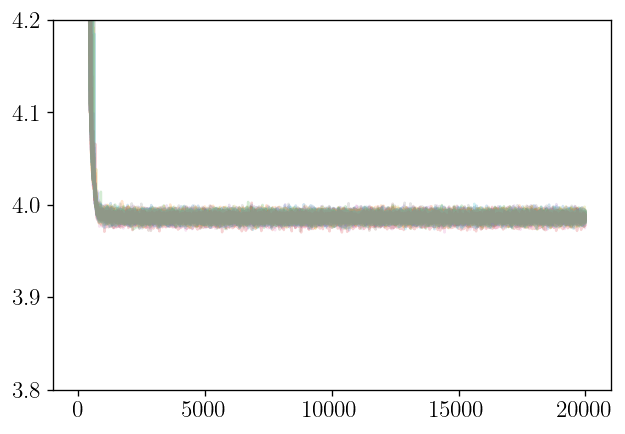

In [10]:
for ns in tqdm(range(Ncs), desc = 'svi_seeds'):
    for nr in tqdm(range(Ncr), desc = 'sim_seeds'):
        svi_results = svi_results_svi_sim[ns][nr]
        plt.plot(np.log10(svi_results.losses), alpha = 0.2)
        plt.ylim([3.8,4.2])

In [11]:
for ns in tqdm(range(Ncs), desc = 'svi_seeds'):
    for nr in tqdm(range(Ncr), desc = 'sim_seeds'):
        svi_results = svi_results_svi_sim[ns][nr]
        print(svi_results.params['scale'])

svi_seeds: 100%|██████████| 1/1 [00:00<00:00, 283.30it/s]

7.7738705
8.4822235
9.068067
8.536263
9.985912
7.792388
7.557901
7.350017
8.433139
6.423786


In [12]:
sum_gp_samples_svi_sim = []
for ns in tqdm(svi_seeds, desc = 'svi_seeds'):
    sum_gp_samples_sim = []
    for nr in tqdm(sim_seeds, desc = 'sim_seeds'):
        sum_gp_samples_sim.append(jnp.exp(gp_samples_svi_sim[ns][nr]).sum(axis = 1))
    sum_gp_samples_svi_sim.append(sum_gp_samples_sim)

svi_seeds: 100%|██████████| 1/1 [00:00<00:00, 18.96it/s]


In [13]:
print(sum_gp_samples_svi_sim[0][0])

[2082.1792 1643.0005 1546.3923 1805.0967 1816.4827 2150.3032 1768.5325
 1795.3352 1816.3582 2175.5532 2148.4355 2055.3965 2563.966  1855.696
 1619.1985 1754.662  1523.0856 1598.0437 1934.212  1715.7561 2168.8616
 1708.4941 1677.2158 2805.8892 1914.6111 2066.241  1759.1792 2041.6976
 1591.1128 2101.79   1642.5458 1602.166  1352.1042 1881.8562 2036.7361
 1433.2811 2344.259  2099.5005 2165.3645 1888.5431 1837.6143 1799.4429
 2075.4111 1727.6511 1686.1692 1702.656  1575.1165 1536.6902 1497.1812
 1869.9579 1842.0698 2335.5623 1971.5011 1848.5427 2216.6365 1611.0728
 1775.2502 2087.9424 1923.9396 1583.4326 1908.7094 2203.6963 2008.4163
 1766.4396 1813.73   2246.1653 1472.2533 1620.2349 1707.9888 2153.5557
 1979.074  1562.0193 1947.4678 1742.528  2283.7925 2090.8564 1530.0199
 2271.0981 1688.3542 2071.2642 1690.7329 1679.0045 1410.6511 1902.5507
 1315.1704 1650.6096 2357.203  1804.144  2453.3025 1702.2996 1945.7756
 2062.0315 1904.1992 2136.306  1719.2875 2074.5474 1687.7273 2452.2747
 1976.1

In [14]:
for ns in tqdm(svi_seeds, desc = 'svi_seeds'):
    for nr in tqdm(sim_seeds, desc = 'sim_seeds'):
        if np.isnan(sum_gp_samples_svi_sim[ns][nr][0]):
            print(ns, nr)

svi_seeds: 100%|██████████| 1/1 [00:00<00:00,  8.59it/s]


svi_seeds:   0%|          | 0/1 [00:00<?, ?it/s]

/home/edr76/.conda/envs/jax/lib/python3.11/site-packages/numpy/lib/histograms.py:883: RuntimeWarning: divide by zero encountered in divide
  return n/db/n.sum(), bin_edges
/home/edr76/.conda/envs/jax/lib/python3.11/site-packages/numpy/lib/histograms.py:883: RuntimeWarning: invalid value encountered in divide
  return n/db/n.sum(), bin_edges
svi_seeds: 100%|██████████| 1/1 [00:02<00:00,  2.56s/it]


Text(0, 0.5, '$\\mathrm{Density}$')

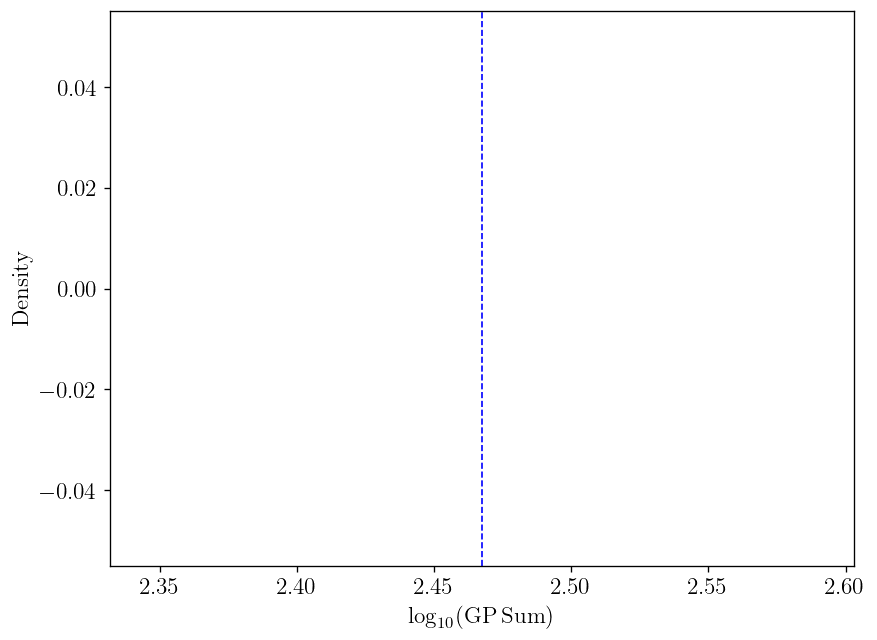

In [15]:
fig = plt.figure(figsize = (8,6))
ax = fig.add_subplot(111)
for ns in tqdm(svi_seeds, desc = 'svi_seeds'):
    for nr in tqdm(sim_seeds, desc = 'sim_seeds'):
        if np.isnan(sum_gp_samples_svi_sim[ns][nr][0]):
            continue
        else:
            ax.hist(jnp.log10(sum_gp_samples_svi_sim[ns][nr]), np.linspace(4.4,4.8,40), alpha = 0.05, color = 'C0', density = True)
ax.axvline(jnp.log10(temp_dict['blg'].sum()), lw = 1, c = 'b', ls = '--')
ax.set_xlabel(r'$\log_{10}(\mathrm{GP\,Sum})$')
ax.set_ylabel(r'$\mathrm{Density}$')

svi_seeds:   0%|          | 0/1 [00:00<?, ?it/s]


IndexError: list index out of range

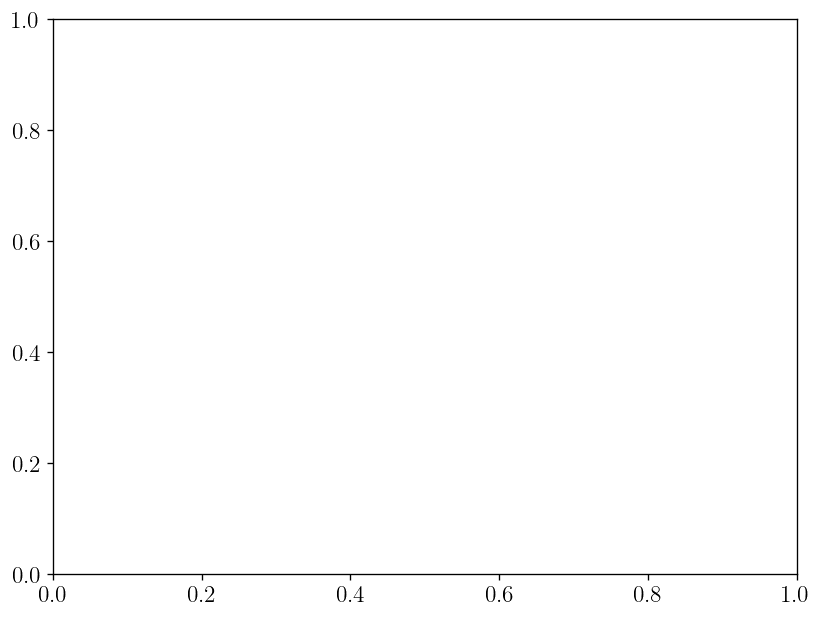

In [16]:
c_sim_seeds = np.arange(10)
c_svi_seeds = [5]

fig = plt.figure(figsize = (8,6))
ax = fig.add_subplot(111)
for ns in tqdm(c_svi_seeds, desc = 'svi_seeds'):
    for nr in tqdm(c_sim_seeds, desc = 'sim_seeds'):
        if np.isnan(sum_gp_samples_svi_sim[ns][nr][0]):
            continue
        else:
            ax.hist(jnp.log10(sum_gp_samples_svi_sim[ns][nr]), np.linspace(4.4,4.8,40), alpha = 0.2, color = 'C0', density = True)
ax.axvline(jnp.log10(temp_dict['blg'].sum()), lw = 1, c = 'b', ls = '--')
ax.set_xlabel(r'$\log_{10}(\mathrm{GP\,Sum})$')
ax.set_ylabel(r'$\mathrm{Density}$')

In [ ]:
from models.poissonian_ed_100 import EbinPoissonModel # to set GPU at the beginning

ebinmodel = EbinPoissonModel(
        # all parameters
        rig_temp_list = rig_temp_list,
        hyb_temp_list = hyb_temp_list,
        var_temp_list = var_temp_list,
        is_gp = is_gp,
        gp_deriv = gp_deriv,
        data_file = data_file,
        rig_temp_sim = rig_temp_sim,
        hyb_temp_sim = hyb_temp_sim,
        var_temp_sim = var_temp_sim,
        is_custom_blg= is_custom_blg,
        custom_blg_id = custom_blg_id,
        sim_seed = sim_seed,
        Nu = Nu,
        u_option = u_option,
        u_grid_type = u_grid_type,
        u_weights = u_weights,
        Np = Np,
        p_option = p_option,
        Nsub = Nsub,
        ebin = ebin,
        is_float64 = is_float64,
        debug_nans = debug_nans,
        no_ps_mask = no_ps_mask,
        p_grid_type = p_grid_type,
        p_weights = p_weights,
        gp_kernel = gp_kernel,
        gp_params = gp_params,
        gp_scale_option = gp_scale_option,
        monotonicity_hyperparameter = monotonicity_hyperparameter,
        )
ebinmodel.config_model(ebin=ebin)

In [ ]:
temp_names_sim = rig_temp_sim + hyb_temp_sim + var_temp_sim # imported from settings file

temp_sample_dict_svi_sim = []

# NOTE: Indices now don't track the IDs. So, you need to keep track of the indices
Ncs = len(c_svi_seeds)
Ncr = len(c_sim_seeds)
for ns in tqdm(range(Ncs), desc = 'svi_seeds'):
    temp_sample_dict_sim = []
    for nr in tqdm(range(Ncr), desc = 'sim_seeds'):
        samples = samples_svi_sim[ns][nr]
        gp_samples = gp_samples_svi_sim[ns][nr]
        temp_sample_dict = ef.generate_temp_sample_maps(samples, ebinmodel, gp_samples = gp_samples)
        temp_sample_dict_sim.append(temp_sample_dict)
    temp_sample_dict_svi_sim.append(temp_sample_dict_sim)

svi_seeds:   0%|          | 0/1 [00:00<?, ?it/s]

iso
psc
bub
pib


























100%|██████████| 1000/1000 [00:01<00:00, 842.43it/s]


ics


























100%|██████████| 1000/1000 [00:01<00:00, 850.50it/s]


iso
psc
bub
pib


























100%|██████████| 1000/1000 [00:01<00:00, 889.03it/s]


ics


























100%|██████████| 1000/1000 [00:01<00:00, 865.08it/s]


iso
psc
bub
pib


























100%|██████████| 1000/1000 [00:01<00:00, 849.55it/s]


ics
























100%|██████████| 1000/1000 [00:01<00:00, 920.20it/s]


iso
psc
bub
pib


























100%|██████████| 1000/1000 [00:01<00:00, 850.49it/s]


ics


























100%|██████████| 1000/1000 [00:01<00:00, 884.56it/s]


iso
psc
bub
pib


























100%|██████████| 1000/1000 [00:01<00:00, 838.37it/s]


ics


























100%|██████████| 1000/1000 [00:01<00:00, 842.18it/s]


iso
psc
bub
pib


























100%|██████████| 1000/1000 [00:01<00:00, 847.17it/s]


ics


























100%|██████████| 1000/1000 [00:01<00:00, 849.10it/s]


iso
psc
bub
pib
























100%|██████████| 1000/1000 [00:01<00:00, 944.89it/s]


ics
























100%|██████████| 1000/1000 [00:01<00:00, 955.88it/s]


iso
psc
bub
pib
























100%|██████████| 1000/1000 [00:01<00:00, 956.90it/s]


ics
























100%|██████████| 1000/1000 [00:01<00:00, 953.39it/s]


iso
psc
bub
pib
























100%|██████████| 1000/1000 [00:01<00:00, 914.16it/s]


ics
























100%|██████████| 1000/1000 [00:01<00:00, 929.60it/s]


iso
psc
bub
pib
























100%|██████████| 1000/1000 [00:01<00:00, 929.66it/s]


ics























svi_seeds: 100%|██████████| 1/1 [00:25<00:00, 25.23s/it]


svi_seeds: 100%|██████████| 1/1 [00:01<00:00,  1.55s/it]


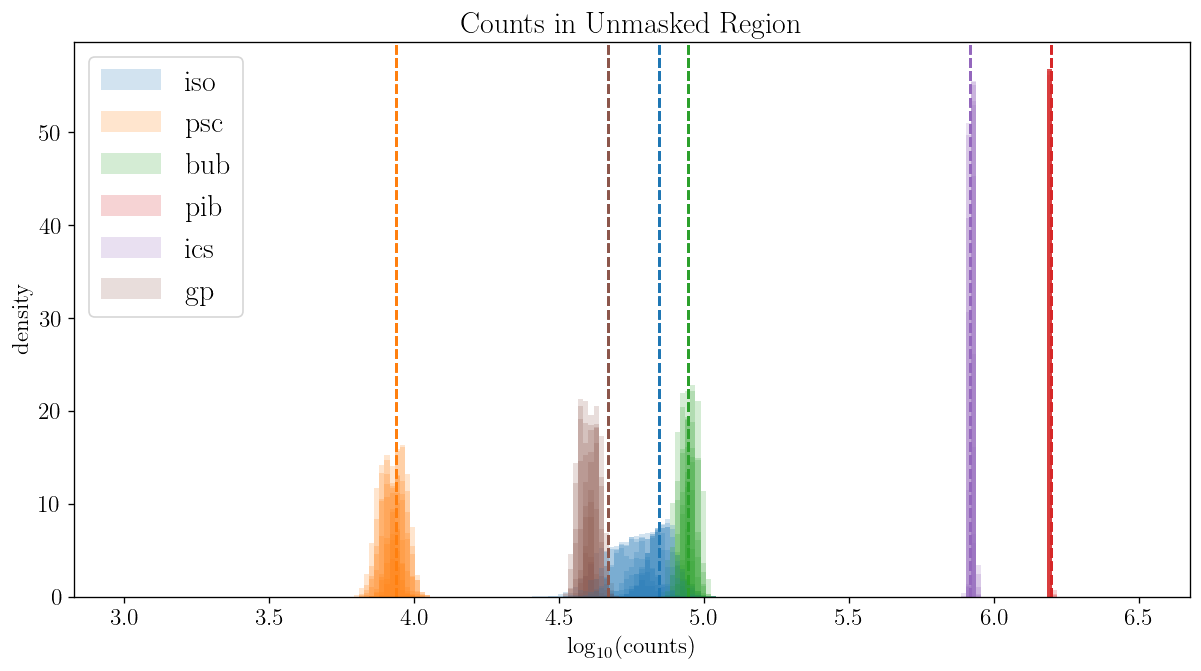

In [ ]:
fig = plt.figure(figsize=(12, 6), dpi= 120)
ax = fig.add_subplot(111)

bins = np.linspace(3,6.5,200)
alpha = 0.2
histtype = 'stepfilled'

all_temp_names = ['iso', 'psc', 'bub', 'pib', 'ics', 'blg', 'gp', 'nfw', 'dsk']
ccodes = ['C0', 'C1', 'C2', 'C3', 'C4', 'C5', 'C5', 'C6', 'C7']
names = list(temp_sample_dict.keys())
ordered_names = [name for name in all_temp_names if name in names]

Ncs = len(c_svi_seeds)
Ncr = len(c_sim_seeds)
c = 0
for ns in tqdm(range(Ncs), desc = 'svi_seeds'):
    for nr in tqdm(range(Ncr), desc = 'sim_seeds'):
        temp_sample_dict = temp_sample_dict_svi_sim[ns][nr]
        for k in range(len(ordered_names)):
            name = ordered_names[k]
            idx = all_temp_names.index(name)
            ccode = ccodes[idx]
            # if name == 'gp':
            #     temp_sum = jnp.exp(temp_sample_dict[name]).sum(axis = 1) # sum over spatial bins
            #     ax.hist(np.log10(temp_sum), bins = bins, alpha = 0.75, label = name, density = True, histtype = 'step', color = ccode)
            # else:
            temp_sum = temp_sample_dict[name].sum(axis = 1) # sum over spatial bins
            if c == 0:
                ax.hist(np.log10(temp_sum), bins = bins, alpha = alpha, label = name, density = True, histtype = histtype, color = ccode)
            else:
                ax.hist(np.log10(temp_sum), bins = bins, alpha = alpha, density = True, histtype = histtype, color = ccode)

        if temp_dict is not None:
            names_sim = temp_names_sim # this piece is provided by the "settings" file since we only save a dictionary with all the fit parameters
            ordered_names_sim = [name for name in all_temp_names if name in names_sim]
            for k in range(len(ordered_names_sim)):
                name = ordered_names_sim[k]
                idx = all_temp_names.index(name)
                ccode = ccodes[idx]
                temp_sum_sim = temp_dict[name].sum(axis = 0)
                ax.axvline(np.log10(temp_sum_sim), linestyle='--', c = ccode)
        c += 1
        
        ax.legend()
        ax.set_xlabel(r'$\log_{10}(\mathrm{counts})$')
        ax.set_ylabel(r'$\mathrm{density}$')
        ax.set_title(r'$\mathrm{Counts\ in\ Unmasked\ Region}$')

In [ ]:
fig = plt.figure(figsize=(12, 6), dpi= 120)
ax = fig.add_subplot(111)

all_temp_names = ['iso', 'psc', 'bub', 'pib', 'ics', 'blg', 'gp', 'nfw', 'dsk']
ccodes = ['C0', 'C1', 'C2', 'C3', 'C4', 'C5', 'C5', 'C6', 'C7']
names = list(temp_sample_dict.keys())

ordered_names = [name for name in all_temp_names if name in names]
for k in range(len(ordered_names)):
    name = ordered_names[k]
    idx = all_temp_names.index(name)
    ccode = ccodes[idx]
    # if name == 'gp':
    #     temp_sum = jnp.exp(temp_sample_dict[name]).sum(axis = 1) # sum over spatial bins
    #     ax.hist(np.log10(temp_sum), bins = bins, alpha = 0.75, label = name, density = True, histtype = 'step', color = ccode)
    # else:
    temp_sum = temp_sample_dict[name].sum(axis = 1) # sum over spatial bins
    ax.hist(np.log10(temp_sum), bins = bins, alpha = 0.75, label = name, density = True, histtype = 'step', color = ccode)

if temp_sim_dict is not None:
    names_sim = temp_sim_names # this piece is provided by the "settings" file since we only save a dictionary with all the fit parameters
    ordered_names_sim = [name for name in all_temp_names if name in names_sim]
    for k in range(len(ordered_names_sim)):
        name = ordered_names_sim[k]
        idx = all_temp_names.index(name)
        ccode = ccodes[idx]
        temp_sum_sim = temp_sim_dict[name].sum(axis = 0)
        ax.axvline(np.log10(temp_sum_sim), linestyle='--', c = ccode)

ax.legend()
ax.set_xlabel(r'$\log_{10}(\mathrm{counts})$')
ax.set_ylabel(r'$\mathrm{density}$')
ax.set_title(r'$\mathrm{Counts\ in\ Unmasked\ Region}$')